In [5]:
import sys, os
from pathlib import Path

sys.path.append(os.path.abspath(".."))


In [3]:
from geosimpleclassify.geo_io import load_raster, save_raster
from geosimpleclassify.mosaic import merge_rasters
from geosimpleclassify.clip import clip_raster_with_vector
from geosimpleclassify.preprocess import (
    stack_bands,
    to_float32,
    clip_by_percentile,
    normalize,
    make_valid_mask,
)

import matplotlib.pyplot as plt
import numpy as np


In [10]:
PROJECT_ROOT = Path(".").resolve()

DATA_DIR = PROJECT_ROOT / "data"
RASTER_DIR = DATA_DIR / "Raster" / "R10m_geotiff" / "Milano"
VECTOR_PATH = DATA_DIR / "Vector" / "ProvCM01012025_WGS84.shp"

T32TMR_DIR = RASTER_DIR / "T32TMR_R10m"
T32TNR_DIR = RASTER_DIR / "T32TNR_R10m"

OUTPUT_DIR = RASTER_DIR / "Output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_DIR


(PosixPath('/Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify'),
 PosixPath('/Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data'))

In [11]:
band_code = "B02"

fname_tmr = f"T32TMR_20251103T102221_{band_code}_10m.tif"
fname_tnr = f"T32TNR_20251103T102221_{band_code}_10m.tif"

raster_paths = [
    T32TMR_DIR / fname_tmr,
    T32TNR_DIR / fname_tnr,
]

raster_paths


[PosixPath('/Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/T32TMR_R10m/T32TMR_20251103T102221_B02_10m.tif'),
 PosixPath('/Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/T32TNR_R10m/T32TNR_20251103T102221_B02_10m.tif')]

mosaic arr shape: (1, 10980, 20982)
mosaic saved to: /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/Output/Notebook_B02_mosaic.tif


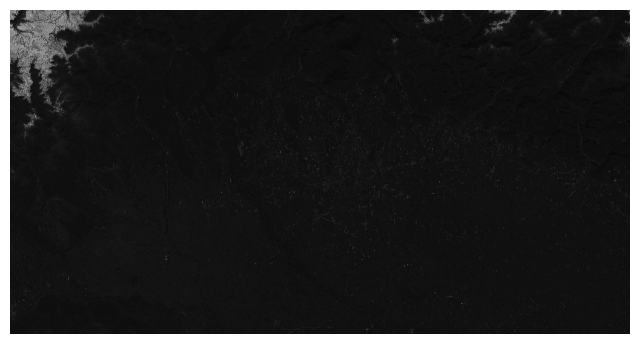

In [12]:
mosaic_out = OUTPUT_DIR / f"Notebook_{band_code}_mosaic.tif"

meta_mosaic, arr_mosaic = merge_rasters(
    [str(p) for p in raster_paths],
    out_path=str(mosaic_out),
)

print("mosaic arr shape:", arr_mosaic.shape)  # 预期 (1, H, W)
print("mosaic saved to:", mosaic_out)

plt.figure(figsize=(8, 8))
plt.imshow(arr_mosaic[0], cmap="gray")
plt.axis("off")
plt.show()


Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/Output/Notebook_B02_clip.tif
clip arr shape: (1, 5335, 6602)


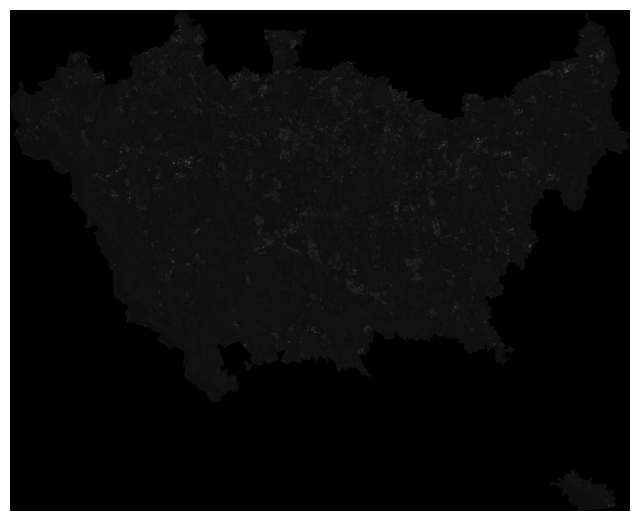

In [13]:
clip_out = OUTPUT_DIR / f"Notebook_{band_code}_clip.tif"

meta_clip, arr_clip = clip_raster_with_vector(
    raster_path=str(mosaic_out),
    vector_path=str(VECTOR_PATH),
    out_path=str(clip_out),
    attr_name="DEN_CM",
    attr_value="Milano",
)

print("clip arr shape:", arr_clip.shape)  # 预期 (1, h, w)

# squeeze 成 2D 看图
img_clip = arr_clip[0] if arr_clip.ndim == 3 else arr_clip

plt.figure(figsize=(8, 8))
plt.imshow(img_clip, cmap="gray")
plt.axis("off")
plt.show()


In [14]:
band_codes = ["B02", "B03", "B04", "B08"]

clipped_bands = []
meta_ref = None

for band_code in band_codes:
    fname_tmr = f"T32TMR_20251103T102221_{band_code}_10m.tif"
    fname_tnr = f"T32TNR_20251103T102221_{band_code}_10m.tif"

    raster_paths = [
        T32TMR_DIR / fname_tmr,
        T32TNR_DIR / fname_tnr,
    ]

    mosaic_out = OUTPUT_DIR / f"Notebook_{band_code}_mosaic.tif"
    meta_mosaic, arr_mosaic = merge_rasters(
        [str(p) for p in raster_paths],
        out_path=str(mosaic_out),
    )

    clip_out = OUTPUT_DIR / f"Notebook_{band_code}_clip.tif"
    meta_clip, arr_clip = clip_raster_with_vector(
        raster_path=str(mosaic_out),
        vector_path=str(VECTOR_PATH),
        out_path=str(clip_out),
        attr_name="DEN_CM",
        attr_value="Milano",
    )

    if meta_ref is None:
        meta_ref = meta_clip

    # 保证是 2D
    if arr_clip.ndim == 3 and arr_clip.shape[0] == 1:
        arr_clip = arr_clip[0]

    clipped_bands.append(arr_clip)

cube = stack_bands(clipped_bands)  # (4, H, W)
print("cube shape:", cube.shape)


Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/Output/Notebook_B02_clip.tif
Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/Output/Notebook_B03_clip.tif
Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/Output/Notebook_B04_clip.tif
Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/Project/GeoSimpleClassify/data/Raster/R10m_geotiff/Milano/Output/Notebook_B08_clip.tif
cube shape: (4, 5335, 6602)


In [15]:
cube = to_float32(cube)
cube = clip_by_percentile(cube, low=1.0, high=99.0, per_band=True)
cube_norm = normalize(cube, per_band=True)
mask = make_valid_mask(cube, nodata_value=0)

print("cube_norm shape:", cube_norm.shape)
print("mask shape:", mask.shape)
print("valid %:", mask.sum() / mask.size)
print("min/max:", cube_norm.min(), cube_norm.max())


cube_norm shape: (4, 5335, 6602)
mask shape: (5335, 6602)
valid %: 0.4473111013759427
min/max: 0.0 1.0


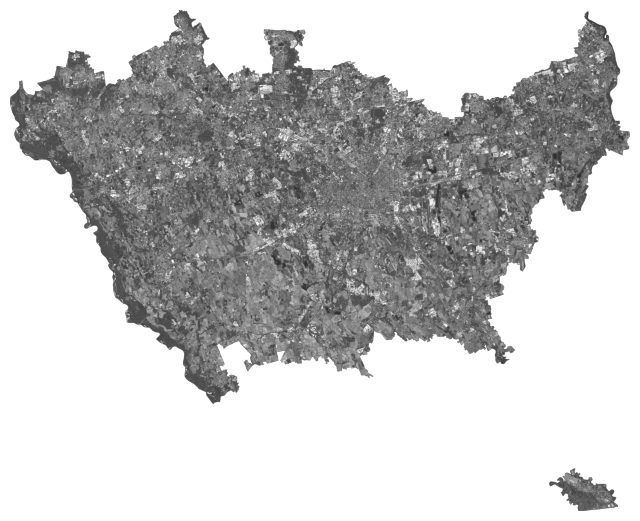

In [16]:
b4 = cube_norm[2]       # B04
mask2d = mask

masked_b4 = np.ma.masked_array(b4, mask=~mask2d)

plt.figure(figsize=(8, 8))
plt.imshow(masked_b4, cmap="gray")
plt.axis("off")
plt.show()
